In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from lib import dpf, panda_baseline_models, panda_datasets, panda_baseline_training
from lib.utils import file_utils, torch_utils, misc_utils

print(torch.__version__, np.__version__)

1.3.1 1.16.4


In [16]:
# Experiment configuration
experiment_name = "baseline_all_sensors2"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 10,
}

In [17]:
# Create model & training buddy
model = panda_baseline_models.PandaBaselineModel(use_prev_state=True, units=32)
buddy = torch_utils.TrainingBuddy(experiment_name, model, log_dir="logs/baseline", checkpoint_dir="checkpoints/baseline")

Using device: cuda
Loaded checkpoint from path: checkpoints/baseline/baseline_all_sensors2-0000000000022830.ckpt


In [5]:
# Load dataset
trainset = panda_datasets.PandaDynamicsDataset(
    "data/pull-test.hdf5",
    "data/push-test.hdf5",
    **dataset_args
)

Parsed data: 389533 active, 195332 inactive
Keeping: 194766


In [10]:
# trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(5):
#     print("Training epoch", i)
#     panda_baseline_training.train(buddy, model, trainset_loader, log_interval=100, state_noise_std=0.2)

# trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
# for i in range(5):
#     print("Training epoch", i)
#     panda_baseline_training.train(buddy, model, trainset_loader, log_interval=100, state_noise_std=0.1)

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
for i in range(5):
    print("Training epoch", i)
    panda_baseline_training.train(buddy, model, trainset_loader, log_interval=100, state_noise_std=0.1)

Training epoch 0
......................Epoch loss: 0.001494045
Training epoch 1
.......................Epoch loss: 0.0013617737
Training epoch 2
.......................Epoch loss: 0.0012718755
Training epoch 3
.................Saved checkpoint to path: checkpoints/baseline/baseline_all_sensors2-0000000000020000.ckpt
......Epoch loss: 0.0011796922
Training epoch 4
.......................Epoch loss: 0.0011439486


# Model eval

In [18]:
eval_trajectories_list = []

def load_trajectories(label, validation, include_pull, include_push, max_count=10):
    if validation:
        # Validation set
        files = [
            ("data/pull-test-small.hdf5", max_count),
            ("data/push-test-small.hdf5", max_count)
        ]
    else:
        # Training set
        files = [
            ("data/pull-test.hdf5", max_count),
            ("data/push-test.hdf5", max_count)
        ]
    
    filtered_files = []
    if include_pull:
        filtered_files.append(files[0])
    if include_push:
        filtered_files.append(files[1])

    trajectories = panda_datasets.load_trajectories(
        *filtered_files,
        **dataset_args
    )
    eval_trajectories_list.append((label, trajectories))

load_trajectories("Validation all", validation=True, include_pull=True, include_push=True)
load_trajectories("Validation pull", validation=True, include_pull=True, include_push=False)
load_trajectories("Validation push", validation=True, include_pull=False, include_push=True)

load_trajectories("Training all", validation=False, include_pull=True, include_push=True)
load_trajectories("Training pull", validation=False, include_pull=True, include_push=False)
load_trajectories("Training push", validation=False, include_pull=False, include_push=True)

###############################
###############################
## Validation all
###############################
###############################


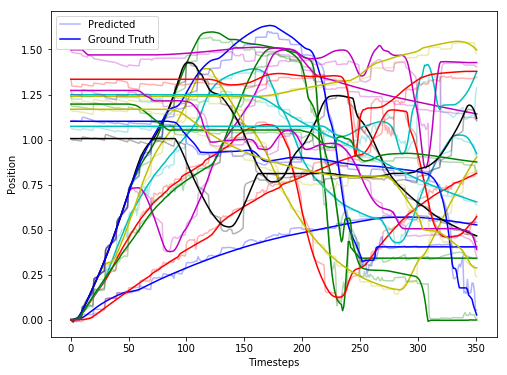

(20, 352, 1)
Position MSE:  0.0013130083
###############################
###############################
## Validation pull
###############################
###############################


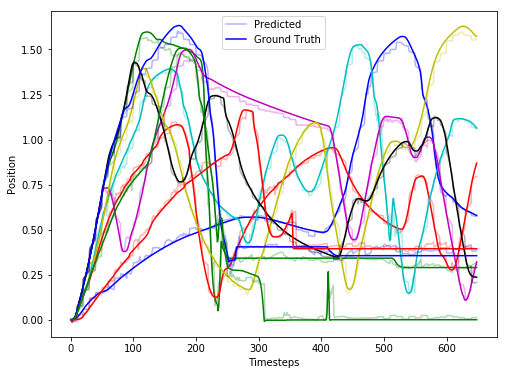

(10, 649, 1)
Position MSE:  0.0009636244
###############################
###############################
## Validation push
###############################
###############################


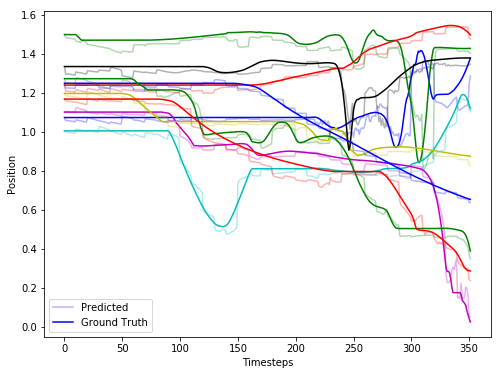

(10, 352, 1)
Position MSE:  0.0016812847
###############################
###############################
## Training all
###############################
###############################


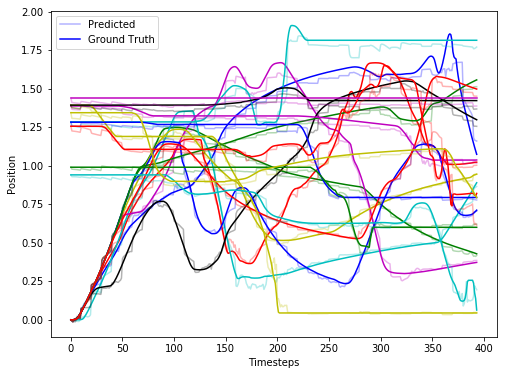

(20, 394, 1)
Position MSE:  0.0011489616
###############################
###############################
## Training pull
###############################
###############################


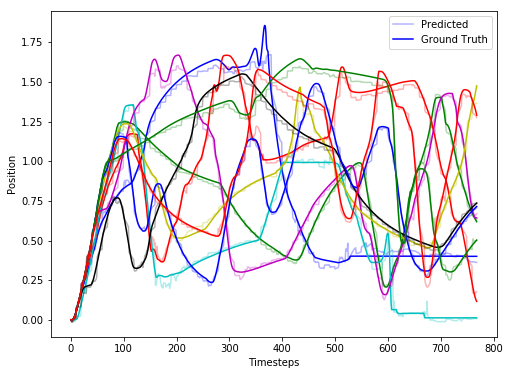

(10, 769, 1)
Position MSE:  0.001177821
###############################
###############################
## Training push
###############################
###############################


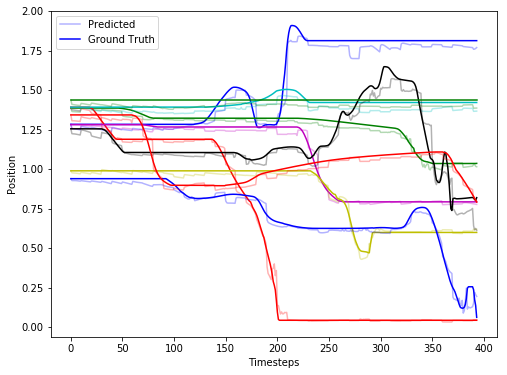

(10, 394, 1)
Position MSE:  0.0011810656


In [19]:
# Evaluate final model
for label, trajectories in eval_trajectories_list:
    print("###############################")
    print("###############################")
    print("##", label)
    print("###############################")
    print("###############################")
    pred, actual = panda_baseline_training.rollout(model, trajectories)
    panda_baseline_training.vis_rollout(pred, actual)

In [20]:
buddy.save_checkpoint()

Saved checkpoint to path: checkpoints/baseline/baseline_all_sensors2-0000000000022830.ckpt
